In [64]:
#import the relevant libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
#Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [67]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Interpretation of the descriptive statistics

- 38,3% of the training set survived
- Age ranges from 0.4 to 80 years. Age has a lot of missing values. Mean and median age are close.
- 50% had no sib or spouse. 75% had 1.0 or less than one sibling or spouse.
- 75% had no parent or child on board
- The mean fare is almost twice as big as median --> outlier
- A lot of missing values in the cabin --> What to do with them?
- only two missing values in the Embarked --> drop them :)
- There were a few big family groups

In [68]:
#The captain died
train_df[train_df['Name'].str.contains('Capt')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S


In [69]:
cabin_df = train_df[train_df['Cabin'].isnull() == False]
cabin_df[cabin_df['Cabin'].str.contains('B22')]

#Harriet was daughter of the captain

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.0,B22,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S


In [70]:
train_df[train_df['Name'].str.contains('Crosby')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.0,B22,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0,B22,S


In [72]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
train_df = train_df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [74]:
#sns.pairplot(dropped_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [75]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


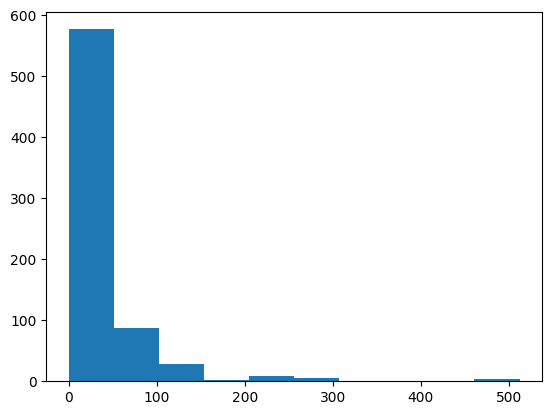

In [76]:
plt.hist(list(train_df['Fare']))
plt.show()

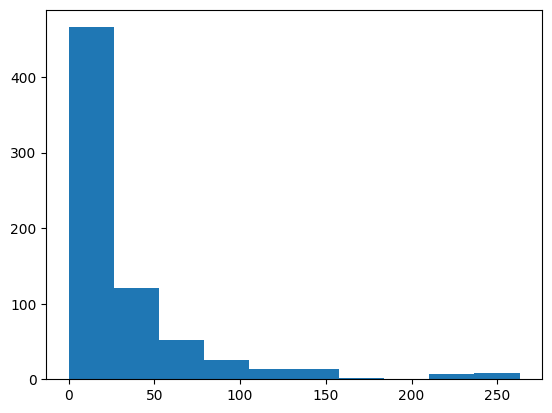

In [77]:
#Drop the outlier
outliers = train_df.index[train_df['Fare'] > 300].to_list()
train_df = train_df.drop(index=outliers)
plt.hist(list(train_df['Fare']))
plt.show()

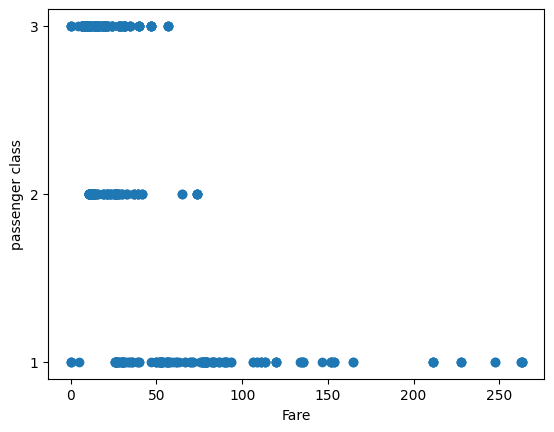

In [78]:
plt.scatter(list(train_df['Fare']), list(train_df['Pclass']))
plt.xlabel('Fare')
plt.ylabel('passenger class')
plt.yticks([1, 2, 3])
plt.show()

In [79]:
def plot_survival_for_class_features(df, feature, bar_width=0.2):
  category_counter = Counter(df[feature].to_list())
  categories = list(category_counter.keys())

  x = ['Survived', 'Died']
  bars = []
  num_passengers = len(df[feature])

  category_stats = {}
  for idx, category in enumerate(categories):
    if (idx == 0):
      bars.append(np.arange(len(x)))
    else:
      bars.append([x_i + bar_width for x_i in bars[idx - 1]])
    cat_df = train_df[train_df[feature] == category]
    counter = Counter(cat_df['Survived'].to_list())
    category_stats[category] = counter


  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
  axs = axs.flatten()
  for idx, category in enumerate(categories):
    class_size = category_stats[category][0] + category_stats[category][1]
    axs[0].bar(bars[idx], [category_stats[category][0], category_stats[category][1]], label=categories[idx], width=bar_width)
    axs[1].bar(bars[idx], [category_stats[category][0]/num_passengers, category_stats[category][1]/num_passengers], width=bar_width)
    axs[2].bar(bars[idx], [category_stats[category][0]/class_size, category_stats[category][1]/class_size], width=bar_width)

  padding = 0 if len(bars) % 2 != 0 else bar_width/2
  middle_bar = bars[len(bars) // 2] if len(bars) % 2 != 0 else bars[len(bars) // 2 - 1]
  fig.suptitle(f"Survival rate vs. {feature}")
  fig.legend()
  axs[0].set_ylabel('# of passenger')
  axs[1].set_ylabel('% of all passenger')
  axs[2].set_ylabel('% of all category')
  axs[0].set_xticks(ticks=[x_i + padding for x_i in middle_bar], labels=x)
  axs[1].set_xticks(ticks=[x_i + padding for x_i in middle_bar], labels=x)
  axs[2].set_xticks(ticks=[x_i + padding for x_i in middle_bar], labels=x)
  plt.show()

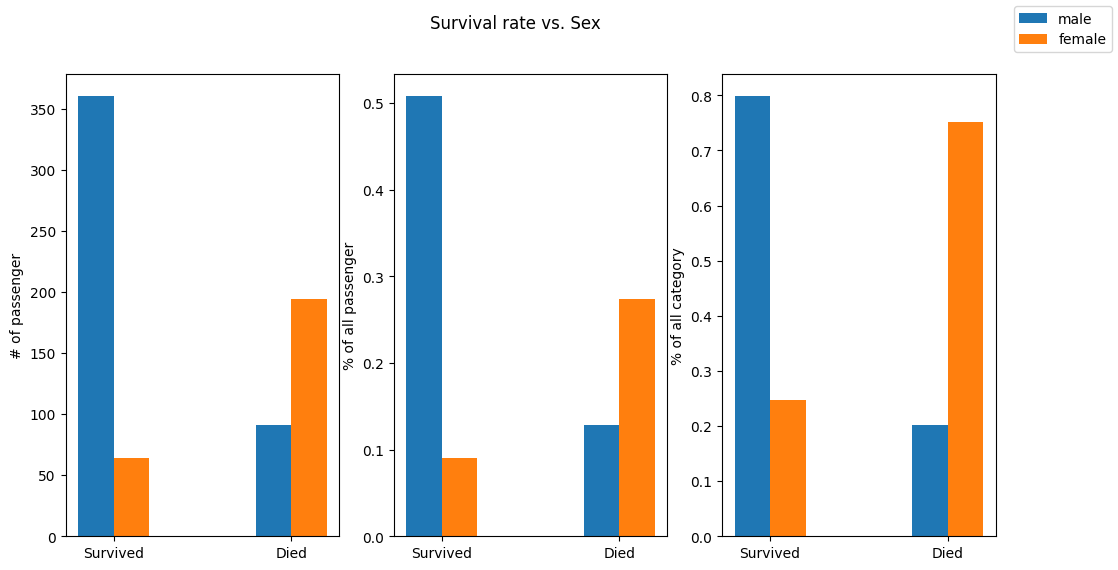

In [80]:
plot_survival_for_class_features(train_df, 'Sex')

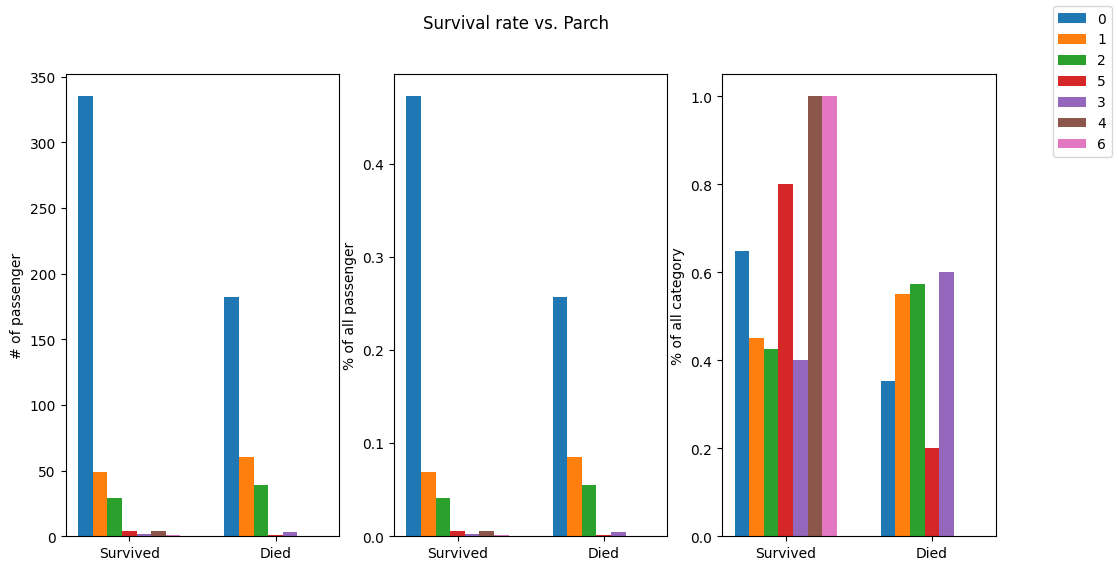

In [82]:
plot_survival_for_class_features(train_df, 'Parch', bar_width=0.1)

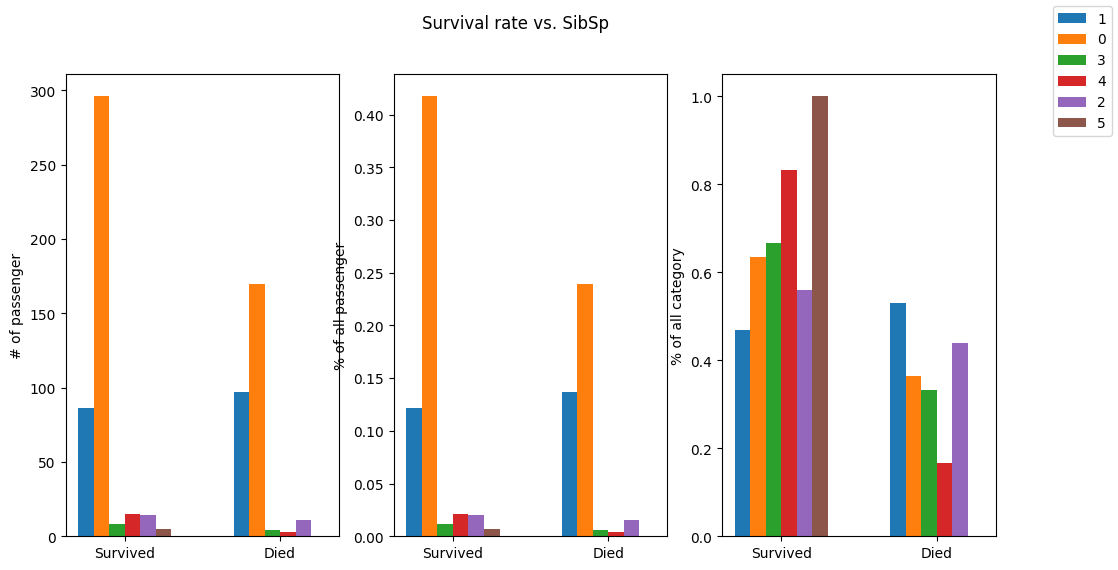

In [85]:
plot_survival_for_class_features(train_df, 'SibSp', bar_width=0.1)

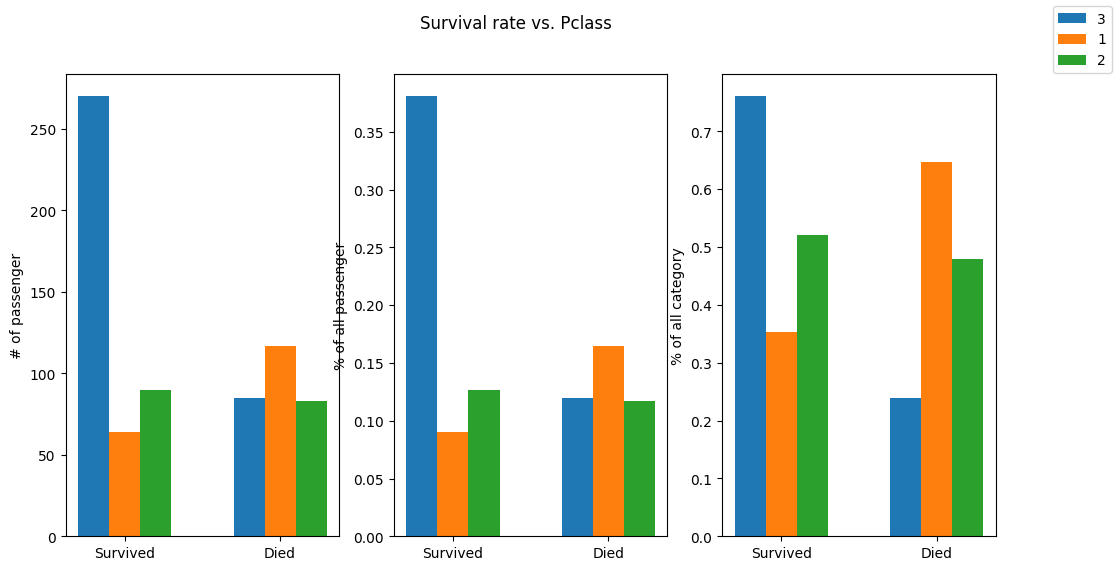

In [86]:
plot_survival_for_class_features(train_df, 'Pclass')